In [1]:
import torch
import torch.autograd
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import numpy as np

class MLP(nn.Module):
    def __init__(self, size_list, dropout = False, dropoutProb = 0.1, batchNorm = False):
        super(MLP, self).__init__()
        layers = []
        self.size_list = size_list
        for i in range(len(size_list) - 2):
            layers.append(nn.Linear(size_list[i],size_list[i+1]))
            layers.append(nn.ReLU())
            
            if batchNorm:
                layers.append(nn.BatchNorm1d(size_list[i+1]))
                
            if dropout:
                layers.append(nn.Dropout(p = dropoutProb))
            
        layers.append(nn.Linear(size_list[-2], size_list[-1]))
        
        # Unpack the list
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class RNN(nn.Module):
    def __init__(self, size_list):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=size_list[0],
            hidden_size=size_list[1],         # rnn hidden unit
            num_layers=len(size_list)-2,           # number of rnn layer
            )

        self.out = nn.Linear(size_list[-2], size_list[-1])

        

    def forward(self, x):
        
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out
    

def train_epoch(model, optimizer, X_train, y_train, criterion):
    model.train()
    
    start_time = time.time()

    optimizer.zero_grad()  

    outputs = model(X_train)
    
    loss = criterion(outputs, y_train)
    
    running_loss = loss.item()

    loss.backward()
    
    optimizer.step()
    
    end_time = time.time()
    
    #print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss




# Optimizer can be 'SGD', 'RMSprop', 'ADAM', 
def nnTrain(X_train, y_train, size_list, dropout = False, dropoutProb = 0.1, batchNorm = False, 
                optimizer = 'SGD', lr = 0.01, n_epochs = 100, LSTM = False):   

    X_train = torch.autograd.Variable(torch.Tensor(X_train.values.astype(float)))
    y_train = torch.autograd.Variable(torch.Tensor(y_train.values.astype(float)))
    
    if LSTM == True:
        X_train = X_train.view(-1, X_train.shape[0], X_train.shape[1])
        model = RNN(size_list)
    else:
        model = MLP(size_list, dropout, dropoutProb, batchNorm)
    
    
    criterion = nn.MSELoss()
    
    if optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr = lr)
    if optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr = lr)
    if optimizer == 'ADAM':
        optimizer = optim.ADAM(model.parameters(), lr = lr)
    
    Train_loss = []
    
    for i in range(n_epochs):
        train_loss = train_epoch(model, optimizer, X_train, y_train, criterion)
        Train_loss.append(train_loss)
    
    return model, Train_loss


def nnTest(model, X_test, y_test):
    X_test = torch.autograd.Variable(torch.Tensor(X_test.values.astype(float)))
    y_test = torch.autograd.Variable(torch.Tensor(y_test.values.astype(float)))
    criterion = nn.MSELoss()
    
    if hasattr(model, 'rnn'):
        X_test = X_test.view(-1, X_test.shape[0], X_test.shape[1])
    
    with torch.no_grad():
        model.eval()        

        outputs = model(X_test)

        loss = criterion(outputs, y_test).detach()
        running_loss = loss.item()
        
        return running_loss
    
def nnPredict(model, X_test):
    X_test = torch.autograd.Variable(torch.Tensor(X_test.values.astype(float)))
    
    if hasattr(model, 'rnn'):
        X_test = X_test.view(-1, X_test.shape[0], X_test.shape[1])
    
    with torch.no_grad():
        model.eval()        
        outputs = model(X_test)
    return np.array(outputs).flatten()

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import pandas_datareader as web
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import neural_network as npy
import os 
import sys


def get_random_tickers(n, ticklist):
    if n >len(ticklist):
        raise Exception('n is bigger than ticklist')
    return np.random.choice(ticklist, size=n, replace=False)
RSVE = []


# Our initial ticklist
ticklist = ['ADS.DE', 'ALV.DE', 'BAS.DE', 'BEI.DE', 'BMW.DE', 'CON.DE', 'DAI.DE', 'DBK.DE', 'DTE.DE', 'EOAN.DE', 'FME.DE',
 'FRE.DE', 'HEI.DE', 'HEN3.DE', 'LHA.DE', 'LIN.DE', 'MRK.DE', 'MUV2.DE', 'RWE.DE', 'SAP.DE', 'SIE.DE', 'TKA.DE', 'VOW3.DE']

# The 7 tickers chosen randomly from this ticklist

ticklist = get_random_tickers(10, ticklist)
#ticklist = ['LIN.DE', 'HEN3.DE', 'DAI.DE', 'FME.DE', 'MUV2.DE', 'SIE.DE', 'DBK.DE']
ticklist = ['CON.DE', 'RWE.DE', 'DTE.DE', 'BEI.DE', 'HEI.DE', 'LIN.DE','FRE.DE', 'ADS.DE','FME.DE','MRK.DE']

tickdict = dict(zip(ticklist, range(1,len(ticklist)+1)))

## Paramteres
d0 = '2001-01-01' # begining of the waiting period
d1 = '2004-01-01' # end of the CV period - beg
d2 = '2006-01-01' # begining of the test period
d3 = '2008-01-01' # end of the test period

dcv1 = '2004-01-01'
dcv2 = '2005-01-01'


### Parameters
norm=True
cv_nlayers=True
cv_nneurones = False
lbd = 0.2 # history weight metric
alpha = 0.09 # risk management metric
cst = 10 #weight metric
delta = 0.91



nneurones = 10
nlayers = 4
drp = False
drpProb = 0.1
batch = False 
opt = 'SGD'
learning_rate = 0.01
n_epochs = 400



# Generate the X matrix and Y matrix and make them have only trading days

dtes = pd.read_csv('trading_days.csv', index_col=0)
tempdt = dtes.copy()
tempdt.set_index('Buy', drop=True, inplace=True)
tempdt.index = pd.to_datetime(tempdt.index)

Y = []
X = pd.DataFrame(columns=['Date', 'EMA10', 'EMA16', 'EMA22', 'SMA10', 'SMA16', 'SMA22','ValueAtRisk', 
                       'Bollu20', 'Bollu26', 'Bollu32', 'Bolld20', 'Bolld26', 'Bolld32',
                       'Mom12', 'Mom18', 'Mom24', 'ACC12', 'ACC18', 'ACC24', 'ROC10', 'ROC16',
                       'ROC22', 'MACD1812', 'MACD2412','MACD3012', 'MACDS18129', 'MACDS24129', 'MACDS30129', 
                       'RSI8', 'RSI14', 'RSI20', 'OBV', 'CHV1010', 'CHV1016', 'CHV1022',
                       'FastK12', 'FastD12', 'FastK18', 'SlowK12', 'FastD18', 'SlowD12',
                       'FastK24', 'SlowK18', 'FastD24', 'SlowD18', 'SlowK24', 'SlowD24',
                       'High', 'Low', 'Open', 'Close', 'Volume', 'AdjClose', 
                       'Ticker','Month', 'DAX', 'ADL', 'Type1', 'Type2', 'Type3', 'Y'])

dax = web.get_data_yahoo('^GDAXI', start=d0, end=d3)
prices = pd.DataFrame(columns=['Ticker', 'High', 'Low', 'Open', 'Close', 'Volume', 'AdjClose', 'Date'])


for tick in ticklist:
    if norm:
        temp = pd.read_csv('tickDataNorm/'+ str(delta).replace('.', '') +'/' + tick.replace('.', '') +'.csv', index_col=0)
    else:
        temp = pd.read_csv('tickData/'+ str(delta).replace('.', '') +'/' + tick.replace('.', '') +'.csv', index_col=0)
    prices = pd.concat([prices, temp.loc[:, ['Ticker', 'High', 'Low', 'Open', 'Close', 'Volume', 'AdjClose', 'Date']]],axis=0, ignore_index=True, sort=False,copy=True)
    # Select dates around events
    temp.set_index('Date', inplace=True, drop=True)
    temp.index = pd.to_datetime(temp.index)
    B = temp.loc[pd.to_datetime(dtes.Buy), 'Close']
    S = temp.loc[pd.to_datetime(dtes.Sell), 'Close']
    temp = temp.loc[tempdt.index, :]
    temp['Y'] = 100*(S.values-B.values)/B.values
    
    mask = np.logical_not(np.isnan(temp['Y'].values))
    temp = temp.loc[mask, :]
    if norm:
        temp.loc[:,'High'] = temp.loc[:,'Norm_High']
        temp.loc[:,'Low'] = temp.loc[:,'Norm_Low']
        temp.loc[:,'Open'] = temp.loc[:,'Norm_Open']
        temp.loc[:,'Close'] = temp.loc[:,'Norm_Close']
        temp.loc[:,'AdjClose'] = temp.loc[:,'Norm_AdjClose']
    #temp = temp.loc[pd.to_datetime(dtes.Buy), :]
    temp['Month'] = temp.index.month
    temp['Date'] = temp.index
    temp['DAX'] = dax.loc[temp.index, 'Adj Close']
    temp.loc[:,'Type'] = tempdt.loc[mask, 'Type'].values
    temp = temp.loc[:,['Date', 'EMA10', 'EMA16', 'EMA22', 'SMA10', 'SMA16', 'SMA22','ValueAtRisk', 
                       'Bollu20', 'Bollu26', 'Bollu32', 'Bolld20', 'Bolld26', 'Bolld32',
                       'Mom12', 'Mom18', 'Mom24', 'ACC12', 'ACC18', 'ACC24', 'ROC10', 'ROC16',
                       'ROC22', 'MACD1812', 'MACD2412','MACD3012', 'MACDS18129', 'MACDS24129', 'MACDS30129', 
                       'RSI8', 'RSI14', 'RSI20', 'OBV', 'CHV1010', 'CHV1016', 'CHV1022',
                       'FastK12', 'FastD12', 'FastK18', 'SlowK12', 'FastD18', 'SlowD12',
                       'FastK24', 'SlowK18', 'FastD24', 'SlowD18', 'SlowK24', 'SlowD24',
                       'High', 'Low', 'Open', 'Close', 'Volume', 'AdjClose', 'Ticker',
                       'Month', 'DAX', 'ADL','Type', 'Y']]
    

    temp['Type1'] = (temp.loc[:,'Type'].values == 1)*1
    temp['Type2'] = (temp.loc[:,'Type'].values == 2)*1
    temp['Type3'] = (temp.loc[:,'Type'].values == 3)*1
    temp = temp.loc[:,['Date', 'EMA10', 'EMA16', 'EMA22', 'SMA10', 'SMA16', 'SMA22','ValueAtRisk', 
                       'Bollu20', 'Bollu26', 'Bollu32', 'Bolld20', 'Bolld26', 'Bolld32',
                       'Mom12', 'Mom18', 'Mom24', 'ACC12', 'ACC18', 'ACC24', 'ROC10', 'ROC16',
                       'ROC22', 'MACD1812', 'MACD2412','MACD3012', 'MACDS18129', 'MACDS24129', 'MACDS30129', 
                       'RSI8', 'RSI14', 'RSI20', 'OBV', 'CHV1010', 'CHV1016', 'CHV1022',
                       'FastK12', 'FastD12', 'FastK18', 'SlowK12', 'FastD18', 'SlowD12',
                       'FastK24', 'SlowK18', 'FastD24', 'SlowD18', 'SlowK24', 'SlowD24',
                       'High', 'Low', 'Open', 'Close', 'Volume', 'AdjClose', 
                       'Ticker','Month', 'DAX', 'ADL', 'Type1', 'Type2', 'Type3', 'Y']]
    print(temp.Ticker.unique())
    X = pd.concat([X, temp], axis=0, ignore_index=True, copy=True, sort=False)


C:\Users\renze\Anaconda3\lib\site-packages\pandas\core\indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
C:\Users\renze\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


['CON.DE']
['RWE.DE']
['DTE.DE']
['BEI.DE']
['HEI.DE']
['LIN.DE']
['FRE.DE']
['ADS.DE']
['FME.DE']
['MRK.DE']


In [4]:
T = X.Ticker.unique()
tickdict = dict(zip(T, range(len(T))))
for tick in T:
    X.loc[X.Ticker==tick,'Ticker']= tickdict[tick]
    
X.sort_values(by=['Date', 'Ticker'], inplace=True)
X.set_index('Date', drop=True, inplace=True)
X = X.loc[((X.index>=pd.to_datetime(d0)) & (X.index<=pd.to_datetime(d3))), :]

## X is generated

## Normalizing features
C = ['EMA10', 'EMA16', 'EMA22', 'SMA10', 'SMA16', 'SMA22','ValueAtRisk', 
                       'Bollu20', 'Bollu26', 'Bollu32', 'Bolld20', 'Bolld26', 'Bolld32',
                       'Mom12', 'Mom18', 'Mom24', 'ACC12', 'ACC18', 'ACC24', 'ROC10', 'ROC16',
                       'ROC22', 'MACD1812', 'MACD2412','MACD3012', 'MACDS18129', 'MACDS24129', 'MACDS30129', 
                       'RSI8', 'RSI14', 'RSI20', 'OBV', 'CHV1010', 'CHV1016', 'CHV1022',
                       'FastK12', 'FastD12', 'FastK18', 'SlowK12', 'FastD18', 'SlowD12',
                       'FastK24', 'SlowK18', 'FastD24', 'SlowD18', 'SlowK24', 'SlowD24',
                       'High', 'Low', 'Open', 'Close', 'Volume', 'AdjClose', 'Ticker',
                       'Month', 'DAX', 'ADL','Type1', 'Type2', 'Type3']

Cnorm = ['EMA10', 'EMA16', 'EMA22', 'SMA10', 'SMA16', 'SMA22','ValueAtRisk', 
                       'Bollu20', 'Bollu26', 'Bollu32', 'Bolld20', 'Bolld26', 'Bolld32',
                       'Mom12', 'Mom18', 'Mom24', 'ACC12', 'ACC18', 'ACC24', 'ROC10', 'ROC16',
                       'ROC22', 'MACD1812', 'MACD2412','MACD3012', 'MACDS18129', 'MACDS24129', 'MACDS30129', 
                       'RSI8', 'RSI14', 'RSI20', 'OBV', 'CHV1010', 'CHV1016', 'CHV1022',
                       'FastK12', 'FastD12', 'FastK18', 'SlowK12', 'FastD18', 'SlowD12',
                       'FastK24', 'SlowK18', 'FastD24', 'SlowD18', 'SlowK24', 'SlowD24',
                       'High', 'Low', 'Open', 'Close', 'Volume', 'AdjClose',
                       'Month', 'DAX', 'ADL']


In [5]:
# Remove outliers
q1, q2 = X['Y'].quantile(0.98), X['Y'].quantile(0.02)
X = X[(X['Y'] < q1) & (X['Y'] > q2)]

## Normalization
Xtrain1 = X.loc[((X.index>pd.to_datetime(d0)) & (X.index<=pd.to_datetime(d1))), C].copy()
Ytrain1 = X.loc[((X.index>pd.to_datetime(d0)) & (X.index<=pd.to_datetime(d1))), 'Y'].copy()

Xmean = np.mean(Xtrain1.loc[:,Cnorm])
Xstdev = np.std(Xtrain1.loc[:,Cnorm])



X_old = X.copy()
X.loc[:, Cnorm] = (X.loc[:, Cnorm]-Xmean)/(Xstdev)

Xcv1 = X.loc[((X.index>pd.to_datetime(d0)) & (X.index<=pd.to_datetime(d1))), C].copy()
Ycv1 = X.loc[((X.index>pd.to_datetime(d0)) & (X.index<=pd.to_datetime(d1))), 'Y'].copy()
Xtrain1 = X.loc[((X.index>pd.to_datetime(d1)) & (X.index<=pd.to_datetime(d2))), C].copy()
Ytrain1 = X.loc[((X.index>pd.to_datetime(d1)) & (X.index<=pd.to_datetime(d2))), 'Y'].copy()


# Vanilla Neural Network

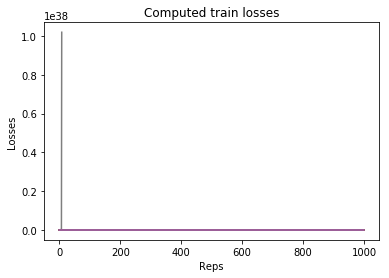

In [36]:
drp = False
drpProb = 0.1
batch = False
optimizer = 'SGD'
learning_rate = 0.02
n_epochs = 1000


layer_ls = list(range(1,8))
neuron_ls = list(range(1,16))


loss_array = np.zeros((len(layer_ls), len(neuron_ls)))
for nlayers in layer_ls:
    for nneurons in neuron_ls:
        ls = [nneurons]*nlayers
        ls = np.insert(ls, 0, Xcv1.shape[1]).tolist()
        ls.append(1)
        nnt, err = npy.nnTrain(Xtrain1, Ytrain1, ls, drp, drpProb, batch, opt, learning_rate, n_epochs) 
        loss_array[nlayers-1,nneurons-1]  = npy.nnTest(nnt, Xcv1, Ycv1)        
        plt.plot(err)        

plt.xlabel('Reps')
plt.ylabel('Losses')
plt.title('Computed train losses')
plt.show()

We see for each network, the loss converges before 1000 training epochs. 

C:\Users\renze\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\renze\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
C:\Users\renze\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
C:\Users\renze\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


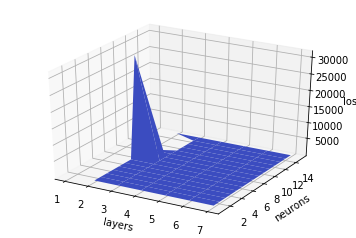

In [37]:
from matplotlib import cm

loss_df = pd.DataFrame(loss_array, index=layer_ls, columns=neuron_ls)
loss_df

from mpl_toolkits.mplot3d import Axes3D
neuron_array, layer_array = np.meshgrid(neuron_ls, layer_ls)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(layer_array, neuron_array, loss_array, cmap=cm.coolwarm)
ax.set_xlabel('layers')
ax.set_ylabel('neurons')
ax.set_zlabel('loss')
plt.show()

In [28]:
loss_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,3.787170,3.783708,3.784104,3.792151,3.799195,3.779632,3.801437,3.792228,3.782649,3.792413,3.787357,3.799966,3.786602,3.786769,3.819743
2,3.782095,3.786403,3.784986,3.782626,3.787333,3.779355,3.782468,3.780941,3.784262,3.786437,3.781793,3.781092,3.794440,3.785257,3.782782
3,3.783604,3.781651,3.778811,3.787477,3.782374,3.784207,3.783889,3.787074,3.783546,3.784503,3.783219,3.783018,3.779996,3.781688,3.780912
4,3.781044,3.783406,3.783622,3.780870,3.782206,3.781634,3.782268,3.782923,3.782773,3.781934,3.782005,3.778643,3.779603,3.781857,3.782268
5,3.782140,3.782181,3.782233,3.782202,3.782421,3.782404,3.782040,3.782186,3.782991,3.781669,3.781499,3.782235,3.782433,3.782196,3.782627
6,3.781859,3.782780,3.782510,3.782500,3.782142,3.782784,3.782862,3.781742,3.782341,3.782380,3.782853,3.781934,3.781837,3.782511,3.782392
7,3.782469,3.782198,3.782161,3.782535,3.782349,3.780908,3.782640,3.781985,3.782113,3.782637,3.782498,3.782314,3.782379,3.782581,3.782252


When increasing nlayers and nneurons do not improve the performance too much, we choose not to add too much complexity to the model. The selected number of layers is 4, and number of neurons per layer is 12.

# Improved Neural Network

We see the train errors converge on a level far lower the testing error. This is a sign of overfitting, so we try dropout. In addition, the optimization may fall into local minimum, so we try RMSprop and Adam. 

To control the covariate shift in the financial data, we also apply batch normalization

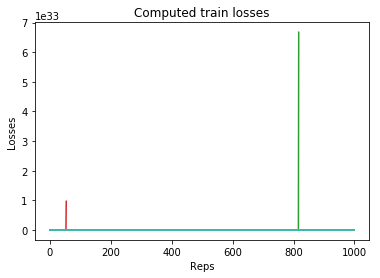

In [34]:
param_dist = {'drp_ls': [True, False],
             'drpProb_ls': [0.3, 0.5 ,0.6, 0.7, 0.9],
             'batch_ls': [True, False],
             'optimizer_ls': ['SGD', 'RMSprop', 'ADAM'],
             'layer_ls': [2,4,6],
              'neuron_ls': [5,7,9,11]}



learning_rate = 0.02
n_epochs = 1000



result = {}
result2 = {}
for drp in param_dist['drp_ls']:
    for drpProb in param_dist['drpProb_ls']:
        for batch in param_dist['batch_ls']:
            for optimizer in param_dist['optimizer_ls']:
                for nlayer in param_dist['layer_ls']:
                    for nneurons in param_dist['neuron_ls']:
                        ls = [nneurons]*nlayers
                        ls = np.insert(ls, 0, Xcv1.shape[1]).tolist()
                        ls.append(1)
                        nnt, err = npy.nnTrain(Xtrain1, Ytrain1, ls, drp, drpProb, batch, opt, learning_rate, n_epochs) 
                        string = 'drp:' + str(drp) + ' dropProb:' + str(drpProb) + ' batch:' + str(batch)\
                        + ' optimizer:' + str(optimizer) + ' nlayer:' + str(nlayer) + ' nneurons:' + str(nneurons)
                        result[string]  = npy.nnTest(nnt, Xcv1, Ycv1) 
                        result2[string] = err
                        if sum(err>20) == 0:
                            plt.plot(err)
                        print(string, result[string])

plt.xlabel('Reps')
plt.ylabel('Losses')
plt.title('Computed train losses')
plt.show()

In [41]:
result

{'drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:2 nneurons:5': 3.7836990356445312,
 'drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:2 nneurons:7': 3.7827348709106445,
 'drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:2 nneurons:9': 3.7811200618743896,
 'drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:2 nneurons:11': 3.7811152935028076,
 'drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:4 nneurons:5': 3.781214952468872,
 'drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:4 nneurons:7': 3.780189275741577,
 'drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:4 nneurons:9': 3.785775899887085,
 'drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:4 nneurons:11': 3.78289794921875,
 'drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:6 nneurons:5': 3.7832376956939697,
 'drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:6 nneurons:7': 3.7891666889190674,
 'drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:6 nneurons:9': 3.782390832901001,
 'd

In [38]:
min(result, key=result.get)

'drp:True dropProb:0.7 batch:False optimizer:RMSprop nlayer:2 nneurons:9'

In [39]:
result['drp:True dropProb:0.7 batch:False optimizer:RMSprop nlayer:2 nneurons:9']

3.7714157104492188

In [ ]:
param_dist = {'drp_ls': [True, False],
             'drpProb_ls': [0.3, 0.5 ,0.6, 0.7, 0.9],
             'batch_ls': [True, False],
             'optimizer_ls': ['SGD', 'RMSprop', 'ADAM'],
             'layer_ls': [2,4,6],
              'neuron_ls': [5,7,9,11]}



learning_rate = 0.02
n_epochs = 1000



result = {}
result2 = {}
for drp in param_dist['drp_ls']:
    for drpProb in param_dist['drpProb_ls']:
        for batch in param_dist['batch_ls']:
            for optimizer in param_dist['optimizer_ls']:
                for nlayer in param_dist['layer_ls']:
                    for nneurons in param_dist['neuron_ls']:
                        ls = [nneurons]*nlayers
                        ls = np.insert(ls, 0, Xcv1.shape[1]).tolist()
                        ls.append(1)
                        nnt, err = npy.nnTrain(Xtrain1, Ytrain1, ls, drp, drpProb, batch, opt, learning_rate, n_epochs) 
                        string = 'drp:' + str(drp) + ' dropProb:' + str(drpProb) + ' batch:' + str(batch)\
                        + ' optimizer:' + str(optimizer) + ' nlayer:' + str(nlayer) + ' nneurons:' + str(nneurons)
                        result[string]  = npy.nnTest(nnt, Xcv1, Ycv1) 
                        result2[string] = err
                        if sum(np.array(err)>20) == 0:
                            plt.plot(err)
                        print(string, result[string])

plt.xlabel('Reps')
plt.ylabel('Losses')
plt.title('Computed train losses')
plt.show()

drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:2 nneurons:5 3.7819952964782715
drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:2 nneurons:7 3.7822320461273193
drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:2 nneurons:9 3.7823078632354736
drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:2 nneurons:11 3.7823002338409424
drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:4 nneurons:5 3.782416820526123
drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:4 nneurons:7 3.782276153564453
drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:4 nneurons:9 3.7819480895996094
drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:4 nneurons:11 3.7824831008911133
drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:6 nneurons:5 3.7825324535369873
drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:6 nneurons:7 3.7825326919555664
drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:6 nneurons:9 3.782357931137085
drp:True dropProb:0.3 batch:True optimizer:SGD nlayer:6

drp:True dropProb:0.5 batch:True optimizer:RMSprop nlayer:6 nneurons:9 3.7822988033294678
drp:True dropProb:0.5 batch:True optimizer:RMSprop nlayer:6 nneurons:11 3.782039165496826
drp:True dropProb:0.5 batch:True optimizer:ADAM nlayer:2 nneurons:5 3.782505750656128
drp:True dropProb:0.5 batch:True optimizer:ADAM nlayer:2 nneurons:7 3.782259464263916
drp:True dropProb:0.5 batch:True optimizer:ADAM nlayer:2 nneurons:9 3.7824106216430664
drp:True dropProb:0.5 batch:True optimizer:ADAM nlayer:2 nneurons:11 3.7825965881347656
drp:True dropProb:0.5 batch:True optimizer:ADAM nlayer:4 nneurons:5 3.782266855239868
drp:True dropProb:0.5 batch:True optimizer:ADAM nlayer:4 nneurons:7 3.7829315662384033
drp:True dropProb:0.5 batch:True optimizer:ADAM nlayer:4 nneurons:9 3.7823874950408936
drp:True dropProb:0.5 batch:True optimizer:ADAM nlayer:4 nneurons:11 3.7827444076538086
drp:True dropProb:0.5 batch:True optimizer:ADAM nlayer:6 nneurons:5 3.7819430828094482
drp:True dropProb:0.5 batch:True optim

drp:True dropProb:0.6 batch:False optimizer:SGD nlayer:6 nneurons:5 3.783845901489258
drp:True dropProb:0.6 batch:False optimizer:SGD nlayer:6 nneurons:7 3.7831246852874756
drp:True dropProb:0.6 batch:False optimizer:SGD nlayer:6 nneurons:9 3.7827236652374268
drp:True dropProb:0.6 batch:False optimizer:SGD nlayer:6 nneurons:11 3.7820732593536377
drp:True dropProb:0.6 batch:False optimizer:RMSprop nlayer:2 nneurons:5 3.781960964202881
drp:True dropProb:0.6 batch:False optimizer:RMSprop nlayer:2 nneurons:7 3.7832565307617188
drp:True dropProb:0.6 batch:False optimizer:RMSprop nlayer:2 nneurons:9 3.781870126724243
drp:True dropProb:0.6 batch:False optimizer:RMSprop nlayer:2 nneurons:11 3.7832183837890625
drp:True dropProb:0.6 batch:False optimizer:RMSprop nlayer:4 nneurons:5 3.782318592071533
drp:True dropProb:0.6 batch:False optimizer:RMSprop nlayer:4 nneurons:7 3.7828853130340576
drp:True dropProb:0.6 batch:False optimizer:RMSprop nlayer:4 nneurons:9 3.7826945781707764
drp:True dropProb

drp:True dropProb:0.7 batch:False optimizer:ADAM nlayer:4 nneurons:7 3.782637357711792
drp:True dropProb:0.7 batch:False optimizer:ADAM nlayer:4 nneurons:9 3.7822532653808594
drp:True dropProb:0.7 batch:False optimizer:ADAM nlayer:4 nneurons:11 3.7817025184631348
drp:True dropProb:0.7 batch:False optimizer:ADAM nlayer:6 nneurons:5 3.7821686267852783
drp:True dropProb:0.7 batch:False optimizer:ADAM nlayer:6 nneurons:7 3.7821996212005615
drp:True dropProb:0.7 batch:False optimizer:ADAM nlayer:6 nneurons:9 3.7808613777160645
drp:True dropProb:0.7 batch:False optimizer:ADAM nlayer:6 nneurons:11 3.782114028930664
drp:True dropProb:0.9 batch:True optimizer:SGD nlayer:2 nneurons:5 3.7824649810791016
drp:True dropProb:0.9 batch:True optimizer:SGD nlayer:2 nneurons:7 3.7825708389282227
drp:True dropProb:0.9 batch:True optimizer:SGD nlayer:2 nneurons:9 3.7824795246124268
drp:True dropProb:0.9 batch:True optimizer:SGD nlayer:2 nneurons:11 3.7824811935424805
drp:True dropProb:0.9 batch:True optimi

C:\Users\renze\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater


drp:True dropProb:0.9 batch:False optimizer:SGD nlayer:4 nneurons:9 nan
drp:True dropProb:0.9 batch:False optimizer:SGD nlayer:4 nneurons:11 nan
drp:True dropProb:0.9 batch:False optimizer:SGD nlayer:6 nneurons:5 3.782390594482422
drp:True dropProb:0.9 batch:False optimizer:SGD nlayer:6 nneurons:7 3.782506227493286
drp:True dropProb:0.9 batch:False optimizer:SGD nlayer:6 nneurons:9 3.7824416160583496
drp:True dropProb:0.9 batch:False optimizer:SGD nlayer:6 nneurons:11 nan
drp:True dropProb:0.9 batch:False optimizer:RMSprop nlayer:2 nneurons:5 3.782471179962158
drp:True dropProb:0.9 batch:False optimizer:RMSprop nlayer:2 nneurons:7 3.783975601196289
drp:True dropProb:0.9 batch:False optimizer:RMSprop nlayer:2 nneurons:9 3.7888526916503906
drp:True dropProb:0.9 batch:False optimizer:RMSprop nlayer:2 nneurons:11 nan
drp:True dropProb:0.9 batch:False optimizer:RMSprop nlayer:4 nneurons:5 3.7824971675872803
drp:True dropProb:0.9 batch:False optimizer:RMSprop nlayer:4 nneurons:7 nan
drp:True

drp:False dropProb:0.3 batch:False optimizer:ADAM nlayer:4 nneurons:7 3.782461404800415
drp:False dropProb:0.3 batch:False optimizer:ADAM nlayer:4 nneurons:9 3.7824816703796387
drp:False dropProb:0.3 batch:False optimizer:ADAM nlayer:4 nneurons:11 3.7825119495391846
drp:False dropProb:0.3 batch:False optimizer:ADAM nlayer:6 nneurons:5 3.7824442386627197
drp:False dropProb:0.3 batch:False optimizer:ADAM nlayer:6 nneurons:7 3.7825021743774414
drp:False dropProb:0.3 batch:False optimizer:ADAM nlayer:6 nneurons:9 3.7824556827545166
drp:False dropProb:0.3 batch:False optimizer:ADAM nlayer:6 nneurons:11 3.7824885845184326
drp:False dropProb:0.5 batch:True optimizer:SGD nlayer:2 nneurons:5 3.7841310501098633
drp:False dropProb:0.5 batch:True optimizer:SGD nlayer:2 nneurons:7 3.8064756393432617
drp:False dropProb:0.5 batch:True optimizer:SGD nlayer:2 nneurons:9 3.783399820327759
drp:False dropProb:0.5 batch:True optimizer:SGD nlayer:2 nneurons:11 3.789653778076172
drp:False dropProb:0.5 batch:

drp:False dropProb:0.6 batch:True optimizer:RMSprop nlayer:2 nneurons:9 3.7830698490142822
drp:False dropProb:0.6 batch:True optimizer:RMSprop nlayer:2 nneurons:11 3.7877037525177
drp:False dropProb:0.6 batch:True optimizer:RMSprop nlayer:4 nneurons:5 3.782834053039551
drp:False dropProb:0.6 batch:True optimizer:RMSprop nlayer:4 nneurons:7 3.7841103076934814
drp:False dropProb:0.6 batch:True optimizer:RMSprop nlayer:4 nneurons:9 3.8018383979797363
drp:False dropProb:0.6 batch:True optimizer:RMSprop nlayer:4 nneurons:11 3.7845327854156494
drp:False dropProb:0.6 batch:True optimizer:RMSprop nlayer:6 nneurons:5 3.8266186714172363
drp:False dropProb:0.6 batch:True optimizer:RMSprop nlayer:6 nneurons:7 3.7831175327301025
drp:False dropProb:0.6 batch:True optimizer:RMSprop nlayer:6 nneurons:9 3.7825467586517334
drp:False dropProb:0.6 batch:True optimizer:RMSprop nlayer:6 nneurons:11 3.783315420150757
drp:False dropProb:0.6 batch:True optimizer:ADAM nlayer:2 nneurons:5 3.7824833393096924
drp:

drp:False dropProb:0.7 batch:True optimizer:ADAM nlayer:6 nneurons:11 3.7916672229766846
drp:False dropProb:0.7 batch:False optimizer:SGD nlayer:2 nneurons:5 3.7824950218200684
drp:False dropProb:0.7 batch:False optimizer:SGD nlayer:2 nneurons:7 3.7826595306396484
drp:False dropProb:0.7 batch:False optimizer:SGD nlayer:2 nneurons:9 3.782487154006958
drp:False dropProb:0.7 batch:False optimizer:SGD nlayer:2 nneurons:11 3.7827911376953125
drp:False dropProb:0.7 batch:False optimizer:SGD nlayer:4 nneurons:5 3.782479763031006
drp:False dropProb:0.7 batch:False optimizer:SGD nlayer:4 nneurons:7 3.782474994659424
drp:False dropProb:0.7 batch:False optimizer:SGD nlayer:4 nneurons:9 3.782458782196045
drp:False dropProb:0.7 batch:False optimizer:SGD nlayer:4 nneurons:11 3.7824277877807617
drp:False dropProb:0.7 batch:False optimizer:SGD nlayer:6 nneurons:5 3.7824795246124268
drp:False dropProb:0.7 batch:False optimizer:SGD nlayer:6 nneurons:7 3.7824811935424805
drp:False dropProb:0.7 batch:Fals